In [1]:
# check the GPU availability and usage in Google Colab
!nvidia-smi

Sun Nov 26 12:55:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!pip install tensorflow==2.14.0 -q

In [2]:
# imports the necessary libraries for the project
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display
from PIL import Image as PILImage
%matplotlib inline
import matplotlib.pyplot as plt
import shutil


In [3]:
print(tf.__version__)

2.14.0


In [4]:
# Set the directory path for style transfer images
#directory = "./gdrive/MyDrive/Project/style-transfer"

directory = "/content/Project/style-transfer"

temp_dir = "/content/Project/temp"

# # Define the paths for the base image and style reference image
# base_image_path = os.path.join(directory, "content_image.jpg")
# style_reference_image_path = os.path.join(directory, "style_image.jpg")

In [35]:
# Create the directories separately
os.makedirs(directory, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

# Content Image

Run the below cell to upload the Content Image. Make sure to select **just 1 image**

In [5]:
from google.colab import files

content_img = files.upload()

Saving house-1867187_640.jpg to house-1867187_640.jpg


In [6]:
CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp

print("Content image filename :", CONTENT_IMAGE_FN)

Content image filename : house-1867187_640.jpg


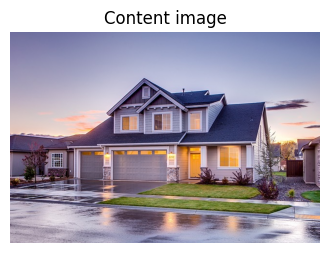

In [7]:
fig = plt.figure(figsize=(4, 4))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

In [10]:
# Path to the file you want to move
source = os.path.abspath(CONTENT_IMAGE_FN)

# Moving the file
shutil.move(source, directory)

'/content/Project/style-transfer/house-1867187_640.jpg'

In [11]:
# Define the paths for the base image
base_image_path = os.path.join(directory, CONTENT_IMAGE_FN)
base_image_path

'/content/Project/style-transfer/house-1867187_640.jpg'

# Style Image

Run the below cell to upload the Style Image. Make sure to select **just 1 image**

In [12]:
style_img = files.upload()

Saving images.jpg to images.jpg


In [13]:
STYLE_IMAGE_FN = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN.strip().replace(" ", "_")

if STYLE_IMAGE_FN != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN, STYLE_IMAGE_FN_temp)
  STYLE_IMAGE_FN = STYLE_IMAGE_FN_temp

print("Style image filename :", STYLE_IMAGE_FN)

Style image filename : images.jpg


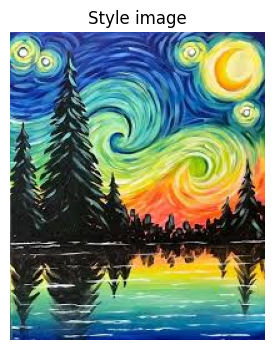

In [14]:
fig = plt.figure(figsize=(4, 4))
img = plt.imread(STYLE_IMAGE_FN)
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

In [15]:
# Path to the file you want to move
source = os.path.abspath(STYLE_IMAGE_FN)

# Moving the file
shutil.move(source, directory)

'/content/Project/style-transfer/images.jpg'

In [16]:
# Define the paths for the style reference image
style_reference_image_path = os.path.join(directory, STYLE_IMAGE_FN)

#Preprocessing Image

This function is used to Preprocess the image with help of VGG19.

VGGNet was invented by VGG (Visual Geometry Group) from University of Oxford, Though VGGNet was the 1st runner-up, not the winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task, which has significantly improvement over ZFNet (The winner in 2013) and AlexNet (The winner in 2012). And GoogLeNet is the winner of ILSVLC 2014, I will also talk about it later.) Nevertheless, VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.

VGG19 is a model, with weights pre-trained on ImageNet.ImageNet, is a dataset of over 15 millions labeled high-resolution images with around 22,000 categories. ILSVRC uses a subset of ImageNet of around 1000 images in each of 1000 categories. In all, there are roughly 1.3 million training images, 50,000 validation images and 100,000 testing images.

In [17]:
# Define the desired dimensions for the generated image
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [18]:
# Preprocess the image
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [19]:
# Convert the generated image back to its original format
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# **Define Loss Function**

 loss functions to measure both content preservation and style emulation.

In [20]:
# Calculate the Gram matrix for a given tensor
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [21]:
# Calculate the style loss between a style image and a combination image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

In [22]:
# Calculate the content loss between a base image and a combination image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [23]:
# Calculate the total variation loss for a given image
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Loading Model

Building the VGG19 model

In [24]:
# Load the VGG19 model pre-trained on ImageNet
model = vgg19.VGG19(weights="imagenet", include_top=False)
print('Model loaded.')

80134624/80134624 [==============================] - 0s 0us/step
Model loaded.


In [25]:
# Create a dictionary mapping layer names to their outputs
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [26]:
# Build a feature extraction model using VGG19
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification

In [27]:
# Define the style layer names and content layer name
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

In [28]:
# Set the weights for loss calculation
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [29]:
# Compute the total loss for the combination image
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [30]:
# Compute the loss and gradients for the combination image
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [31]:
# Set the optimizer with a learning rate decay
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

In [32]:
# Preprocess the base image, style reference image, and combination image
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

# Generate Image

Run the below cells to generate the image

In [47]:
# Set the prefix for saving the generated images
result_prefix = "generated"

# Set the number of iterations for optimization
iterations = 5000


# Perform the style transfer optimization loop
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = os.path.join(temp_dir, f"{result_prefix}_at_iteration_{i}.png")
        keras.utils.save_img(fname, img)

Iteration 100: loss=2895.03
Iteration 200: loss=2879.05
Iteration 300: loss=2864.22
Iteration 400: loss=2850.43
Iteration 500: loss=2837.62
Iteration 600: loss=2825.68
Iteration 700: loss=2814.51
Iteration 800: loss=2804.08
Iteration 900: loss=2794.31
Iteration 1000: loss=2785.15
Iteration 1100: loss=2776.54
Iteration 1200: loss=2768.45
Iteration 1300: loss=2760.82
Iteration 1400: loss=2753.65
Iteration 1500: loss=2746.90
Iteration 1600: loss=2740.53
Iteration 1700: loss=2734.49
Iteration 1800: loss=2728.78
Iteration 1900: loss=2723.38
Iteration 2000: loss=2718.26
Iteration 2100: loss=2713.42
Iteration 2200: loss=2708.83
Iteration 2300: loss=2704.48
Iteration 2400: loss=2700.36
Iteration 2500: loss=2696.44
Iteration 2600: loss=2692.73
Iteration 2700: loss=2689.19
Iteration 2800: loss=2685.84
Iteration 2900: loss=2682.64
Iteration 3000: loss=2679.60
Iteration 3100: loss=2676.71
Iteration 3200: loss=2673.94
Iteration 3300: loss=2671.31
Iteration 3400: loss=2668.80
Iteration 3500: loss=26

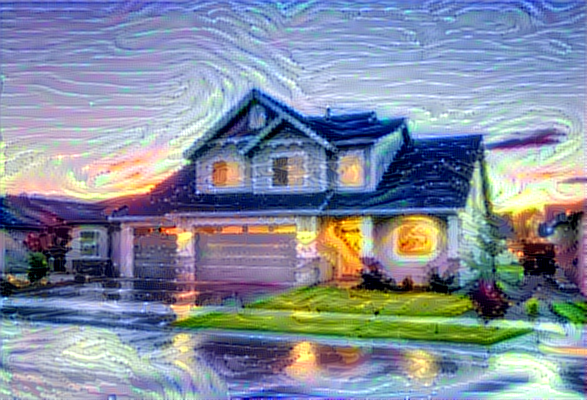

In [48]:
# Save and display the final generated image
filename = "result_at_iteration_"+str(iterations)+".png"
image_path = os.path.join("/content/", filename)
display(Image(temp_dir+"/"+result_prefix + "_at_iteration_"+str(iterations)+".png"))
PILImage.open(temp_dir+"/"+result_prefix + "_at_iteration_"+str(iterations)+".png").save(image_path)

# Image Comparsion

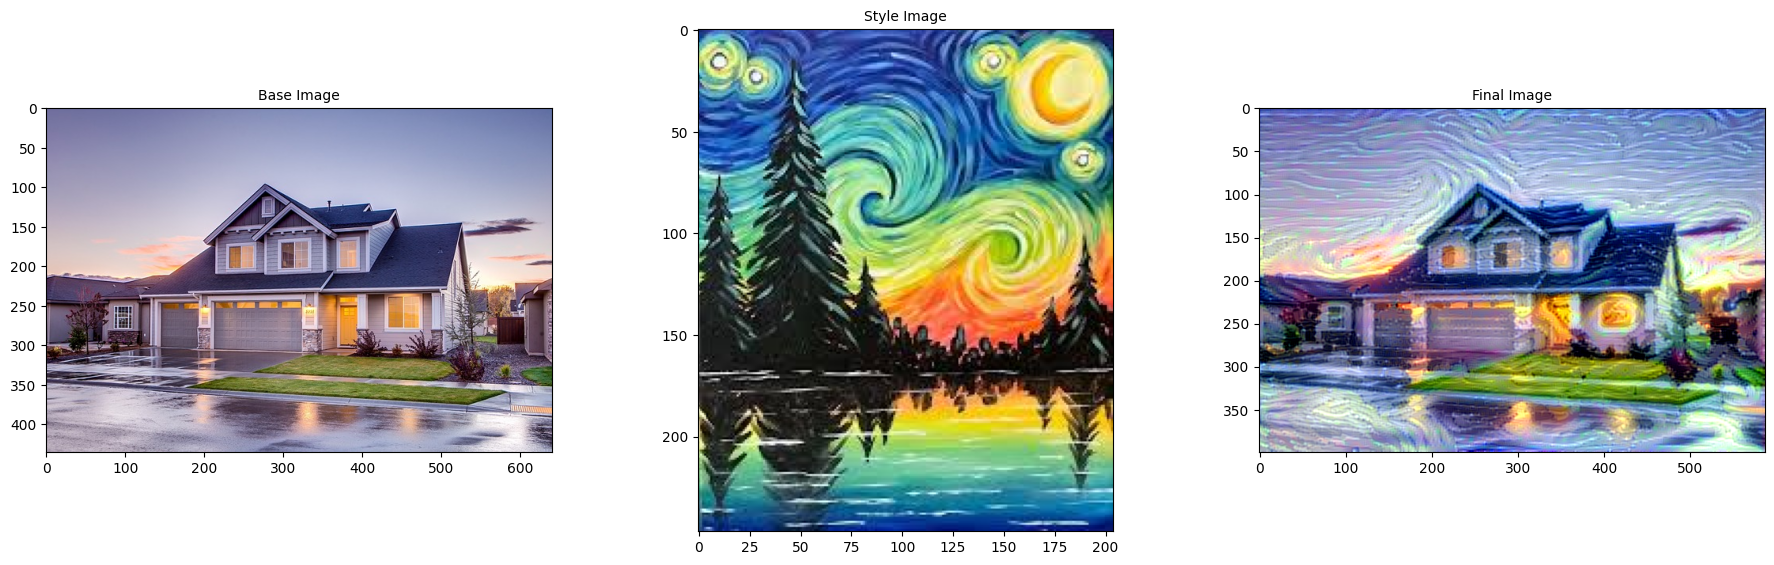

In [49]:
from keras.preprocessing.image import load_img

plt.figure(figsize=(30,30))
plt.subplot(4,4,1)
plt.title("Base Image",fontsize=10)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(4,4,2)
plt.title("Style Image",fontsize=10)
img_style = load_img(style_reference_image_path)
plt.imshow(img_style)

plt.subplot(4,4,3)
plt.title("Final Image",fontsize=10)
img_final = load_img(image_path)
plt.imshow(img_final)